In [1]:
#library(scMACS)
library(chromVARmotifs)
library(ArchR)
library(TxDb.Hsapiens.UCSC.hg38.refGene)
library(org.Hs.eg.db)
library(matrixStats)
library(GenomicRanges)
library(parallel)
library(plyranges)




                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   

In [28]:
##########
### Functions for motif analysis (enrichment and chromVar)





## runChromVar is a wrapper for chromVAR from scMACS
## Obj could be a ragged experiment or a sumarized experiment
## motifGRangesList is a list of all motif positions in a GRangesList format
## genome is the reference genome we use


runChromVar <- function(Obj, motifs,
                       genome =  BSgenome.Hsapiens.UCSC.hg38){
    
    if(class(Obj)[1] == "RaggedSummarizedExperiment" & class(motifs)[1]=='GRangesList'){
        
        Obj1 <- RaggedExperiment::compactSummarizedExperiment(RepTiles, i = 'TotalIntensity')
        tmp <- SummarizedExperiment::assays(Obj1)
        tmp[[1]][is.na(tmp[[1]])] = 0
        names(tmp) <- "counts"
        assays(Obj1) <- tmp

	motifGRangesList = motifs
        
    }else if(class(Obj)[1] == "RangedSummarizedExperiment"){
        
        if( !names(assays(Obj)) %in% 'counts'){
        
		
            
        }else if(class(motifs)[1] == 'GRangesList'){
            
            Obj1 = Obj
	    motifGRangesList = motifs
	    
        }else if(class(motifs)[1] == 'character' & any(names(metadata(Obj)) %in% motifs)){
            
            Obj1 = Obj
	    motifGRangesList = metadata(Obj)[[motifs]]
	    
        }else{

	    stop('Error: No motifset found. Check input')
	}
        
    }else{
    
        stop('Error: Wrong Input Object. Must be either a RaggedExperiment or a RangedSummarizedExperiment')
    }     

    CisbpAnno <- chromVAR::getAnnotations(motifGRangesList, rowRanges = rowRanges(Obj1))

    Obj1 <- chromVAR::addGCBias(Obj1, genome = genome)
    
    dev <- chromVAR::computeDeviations(object = Obj1, 
                         annotations = CisbpAnno)
    
    return(dev)
}




#################      Category          Not in Category       Total
## Group1      length(Group1Cat)        length(OnlyGroup1)       m 
## Group2      length(Group2Cat)        length(OnlyGroup2)       n
# Total                  k
                 
### Enrichment test for GRanges. Test for enrichment of Category within Group1
### @Group1 - A GRanges object for one set of positions
### @Group2 - The background GRanges object, non-overlapping with Group1.
### @Category - A GRanges object of known locations, such as motifs, that you want to test for enrichment in Group1.
### @type - Default is null. You can use this to pull out or simplify the test to a metadata column within the GRanges 
###          for Group1 and Group2. For example, if you want to test for enrichment of all genes, instead of open regions. 
###          If type = null, then it will just use the number of Ranges instead of the number of unique 
###           entries in column 'type'
EnrichedRanges <- function(Group1, Group2, Category, type = NULL, returnTable = FALSE){
    
    Group1Cat <- plyranges::filter_by_overlaps(Group1, Category) 
    Group2Cat <- plyranges::filter_by_overlaps(Group2, Category)
   
    OnlyGroup1 <- plyranges::filter_by_non_overlaps(Group1, Category)
    OnlyGroup2 <- plyranges::filter_by_non_overlaps(Group2, Category)
    
    if(returnTable & is.null(type)){

        dt_table <- data.frame(Group1 = c(length(Group1Cat), length(OnlyGroup1)), 
                               Group2 = c(length(Group2Cat), length(OnlyGroup2)), 
                       row.names = c('In Category', 'Not in Category')) 
    
        return(t(dt_table))
        
    }else if(returnTable & 
             sum(c(colnames(mcols(Group1)),colnames(mcols(Group2))) %in% type) == 2 &
             length(type) == 1){
        
       dt_table <- data.frame(Group1 = c(length(unique(GenomicRanges::mcols(Group1Cat)[,type])), 
                                          length(unique(GenomicRanges::mcols(OnlyGroup1)[,type]))), 
                               Group2 = c(length(unique(GenomicRanges::mcols(Group2Cat)[,type])), 
                                         length(unique(GenomicRanges::mcols(OnlyGroup2)[,type]))), 
                       row.names = c('In Category', 'Not in Category')) 
    
        return(t(dt_table))
       
    }else if(returnTable){
        
        stop('Error: Incorrect method or column name. Please check input')      
    }
    
    if(is.null(type)){
        
       pVal <- phyper(q = length(Group1Cat), 
           m = length(Group1), 
           n = length(Group2),
           k = length(Group1Cat) + length(Group2Cat),
            lower.tail=FALSE)

       enrichment <- (length(Group1Cat)/length(Group1))/(length(Group2Cat)/length(Group2))
        
    }else if(sum(c(colnames(mcols(Group1)),colnames(mcols(Group2))) %in% type) == 2 &
             length(type) == 1){
        
       pVal <- phyper(q = length(unique(mcols(Group1Cat)[,type])), 
           m = length(unique(mcols(Group1)[,type])), 
           n = length(unique(mcols(Group2)[,type])),
           k = length(unique(mcols(Group1Cat)[,type])) + length(unique(mcols(Group2Cat)[,type])),
                     lower.tail=FALSE)
        
       enrichment <- (length(unique(mcols(Group1Cat)[,type]))/length(unique(mcols(Group1)[,type])))/
                    (length(unique(mcols(Group2Cat)[,type]))/length(unique(mcols(Group2)[,type])))
        
    }else{
        
        stop('Error: Incorrect method or column name. Please check input')
        
    }
    
    return(data.frame(p_value = pVal, enrichment = enrichment))
    
}
    
######## Test all motifs for enrichment.
    

MotifEnrichment <- function(Group1, Group2, motifPosList, type = NULL, numCores = 1){
    
    
    allEnrichmentList <- mclapply(motifPosList, function(x){
        
        tmp_df <- EnrichedRanges(Group1, Group2, Category = x, type = type)
        
    }, mc.cores = numCores)
    df_final <- do.call('rbind',  allEnrichmentList)

    df_final$adjp_val <- p.adjust(df_final$p_value)
    df_final$mlog10Padj <- -log10(df_final$adjp_val)
    
    return(df_final)

}
    
############# Pull out all the motifs associated with each gene according to a set of TSS sites

## @TSS_Sites - GRanges objects that are the list of TSS sites of interest. 
##              Must include a column 'name' which has the associated gene name
## @allPeaks - GRanges object of all peaks 
## @TSS_Links - a data.table object that record all the peak-peak links by co-accessibility
##              Must include columns named 'Peak1' and 'Peak2' which contain a string describing
##              each peak in the format 'chr1:100-2000' and must be identical to peaks listed in
##              allPeaks
## @motifPosList - a GRangesList, which each index is a GRanges of all positions 
##                  for a given motif. GRangesList must be named. 
## @numCores - number of cores to multithread over. 
    
    
Gene2Motif <- function(TSS_Sites, allPeaks, TSS_Links, motifPosList, 
                       numCores = 1, verbose = FALSE){
    
    if(verbose){ print('Generating TSS-Peak Network.')}
    
    TSS_Network <- c(TSS_Links$Peak1, TSS_Links$Peak2, 
                           GRangesToString(TSS_Sites)) %>%
                   unique() %>%
                  StringsToGRanges(.) %>% 
                plyranges::filter_by_overlaps(allPeaks, .)
    
    if(verbose){ print('Finding all motifs related to each peak within the TSS-Peak Network.')}
    ##Let's find all the motifs that overlap with each peak within the altTSS Network
    tmpOverlap <- mclapply(seq_along(motifPosList), function(x){
    
        ifelse(count_overlaps(TSS_Network, motifPosList[[x]]) > 0,
           names(motifPosList)[x], NA)
    
    }, mc.cores= numCores)
    
    
    overlap_df <- do.call('cbind', tmpOverlap)
    motifList <- mclapply(c(1:dim(overlap_df)[1]), function(x){
        
        
        ifelse(any(!is.na(overlap_df[x,])),
            list(overlap_df[x,which(!is.na(overlap_df[x,]))]),
            NA)
    
    }, mc.cores= numCores)

    if(verbose){ print('Finding all peaks related to each gene within the TSS-Peak Network.')}
    ##Find all the peaks related to each gene. 
    
    Peak2Gene <- mclapply(unique(TSS_Sites$name), function(x){
    
        geneTSS <- plyranges::filter(TSS_Sites, name == x)  %>% 
                plyranges::filter_by_overlaps(allPeaks, .) %>%
            plyranges::ungroup() %>%
            GRangesToString(.)
    
        tmp <- TSS_Links[Peak1 %in% geneTSS | Peak2 %in% geneTSS,]
    
        if(dim(tmp)[1] > 0){ 
            unique(c(tmp$Peak1, tmp$Peak2, geneTSS))
        }else{
               geneTSS
        }
    
    }, mc.cores = numCores)
    names(Peak2Gene) <- unique(TSS_Sites$name)
    
    

    if(verbose){ print('Linking Motifs to each gene within the TSS-Peak Network')}
    ## Link all the genes to motifs via Peak2Gene and the motifList
    Gene2Motif <- mclapply(Peak2Gene, function(x){
    
        #Find which indices of the AltTSS Network GRanges are linked to that Gene
        tmp <- findOverlaps(StringsToGRanges(x), TSS_Network)
        #Pull up and unlist all the motifs associated with those tiles.
        unlist(motifList[subjectHits(tmp)])
    
    }, mc.cores = numCores)
    
    return(Gene2Motif)
    
}

In [2]:
NK_DEGs <- read.csv('genes_in_common.csv')
NK_DEGs <- unique(NK_DEGs$genes)

In [3]:
NK_Clusters_GC_PM_DM <- loadArchRProject("/home/jupyter/QC/Further_Exploration/NK_Clusters_Pretreatment_Post_Induction_Post_Batch_Correction_PeaksCalled_PeakMatrix_Deviation_Matrix")

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .____

In [4]:
idx_pass <- which(NK_Clusters_GC_PM_DM$Stage == 'Post_Induction')
NK_Clusters_PI <- NK_Clusters_GC_PM_DM[idx_pass,]

In [5]:
peakset <- getPeakSet(NK_Clusters_PI)

In [6]:
peakset

GRanges object with 101213 ranges and 13 metadata columns:
     seqnames              ranges strand |     score replicateScoreQuantile
        <Rle>           <IRanges>  <Rle> | <numeric>              <numeric>
  NK     chr1       826654-827154      * |   19.7321                  0.289
  NK     chr1       827285-827785      * | 2697.2600                  0.938
  NK     chr1       844400-844900      * |   34.5957                  0.482
  NK     chr1       869640-870140      * | 1652.0600                  0.903
  NK     chr1       898654-899154      * |   80.7711                  0.553
  ..      ...                 ...    ... .       ...                    ...
  NK     chrX 155767176-155767676      * |    5.3961                  0.065
  NK     chrX 155820083-155820583      * |   22.4446                  0.342
  NK     chrX 155881028-155881528      * |  797.1860                  0.839
  NK     chrX 155881591-155882091      * |   12.6357                  0.205
  NK     chrX 155966821-15596

In [23]:
Promoter_Peaks <- peakset %>% plyranges::filter(peakType == 'Promoter')

In [8]:
getStartSites <- function(peakSet,

                      TxDb = TxDb.Hsapiens.UCSC.hg38.refGene,

                      Org = org.Hs.eg.db){

   

    if(grepl('data.table|SummarizedExperiment',class(peakSet)[1])){

   

        Granges = ExtractGR(peakSet)

       

    }else if(class(peakSet)[1] == 'GRanges'){

       

        GRanges = peakSet

    }

   

    tss1 <- suppressWarnings(ensembldb::transcriptsBy(TxDb, by = ('gene')))



    names(tss1) <- suppressWarnings(mapIds(Org, names(tss1), "SYMBOL", "ENTREZID"))



    allT <- stack(tss1) %>% GenomicRanges::trim(.) %>% GenomicRanges::promoters(., upstream = 0, downstream = 0) %>%

            plyranges::mutate(exactTSS = start(.)) %>% plyranges::filter(!duplicated(exactTSS)) %>%

            GenomicRanges::trim()



    tpeaks <- plyranges::join_overlap_intersect(allT, GRanges)

   

     return(tpeaks)

}

In [9]:
Promoter_Peaks

GRanges object with 17194 ranges and 13 metadata columns:
     seqnames              ranges strand |      score replicateScoreQuantile
        <Rle>           <IRanges>  <Rle> |  <numeric>              <numeric>
  NK     chr1       827285-827785      * | 2697.26000                  0.938
  NK     chr1       920996-921496      * |  164.32000                  0.656
  NK     chr1       923623-924123      * |  230.24300                  0.701
  NK     chr1       958478-958978      * |    7.82157                  0.142
  NK     chr1       959072-959572      * | 2399.70000                  0.971
  ..      ...                 ...    ... .        ...                    ...
  NK     chrX 155027665-155028165      * |   380.1300                  0.763
  NK     chrX 155070987-155071487      * |  1733.8500                  0.903
  NK     chrX 155071798-155072298      * |    15.3624                  0.336
  NK     chrX 155148857-155149357      * |    20.9847                  0.394
  NK     chrX 1552

In [10]:
genes <- Promoter_Peaks$nearestGene

In [11]:
output <- lapply(Promoter_Peaks$nearestGene, function(x) {
        unlist(strsplit(x,split=","))
    }
)

In [12]:
output <- unname(output)
output <- unlist(output)

In [13]:
idx <- lapply(output,function(x) {
        any(x %in% NK_DEGs)
    }
)

In [14]:
Group1 <- Promoter_Peaks[idx==TRUE,]

In [15]:
length(unique(Group1$nearestGene))

[1] 229

In [18]:
length(NK_DEGs)

[1] 289

In [24]:
Group2 = Promoter_Peaks[idx==FALSE,]

In [25]:
length(unique(Group2$nearestGene))

[1] 11957

In [26]:
intersect(Group1,Group2)

GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: 23 sequences from an unspecified genome; no seqlengths

In [30]:
motifPosList <- getPositions(NK_Clusters_GC_PM_DM)

In [31]:
enrichment <- MotifEnrichment(Group1,Group2,motifPosList, numCores = 55)

In [32]:
head(enrichment)

,p_value,enrichment,adjp_val,mlog10Padj
,<dbl>,<dbl>,<dbl>,<dbl>
TFAP2B_1,0.7827005,0.8662887,1,0
TFAP2D_2,0.9932113,0.8139084,1,0
TFAP2C_3,0.8387447,0.8856895,1,0
TFAP2E_4,0.2015156,1.1317310,1,0
TFAP2A_5,0.6390880,0.9384446,1,0
ARID3A_6,0.0247491,1.2266316,1,0


In [33]:
dim(enrichment)

[1] 870   4

In [60]:
sig_enrichment <- enrichment %>%  filter(p_value <= 0.05 )

In [62]:
sig_enrichment

,p_value,enrichment,adjp_val,mlog10Padj
,<dbl>,<dbl>,<dbl>,<dbl>
ARID3A_6,2.474910e-02,1.226632,1.000000000,0.0000000
HAND1_33,3.426268e-02,1.383390,1.000000000,0.0000000
HEY2_54,7.290911e-03,1.671530,1.000000000,0.0000000
TAL1_62,2.987501e-02,1.475105,1.000000000,0.0000000
HEYL_65,3.801601e-02,1.463325,1.000000000,0.0000000
HAND2_66,3.426268e-02,1.383390,1.000000000,0.0000000
NEUROG2_81,1.963569e-02,1.899756,1.000000000,0.0000000
HES7_83,1.284288e-02,1.691236,1.000000000,0.0000000
HES5_98,7.731864e-03,1.729119,1.000000000,0.0000000


In [61]:
rownames(sig_enrichment)

[1] "ARID3A_6"            "HAND1_33"            "HEY2_54"            
  [4] "TAL1_62"             "HEYL_65"             "HAND2_66"           
  [7] "NEUROG2_81"          "HES7_83"             "HES5_98"            
 [10] "SREBF2_99"           "MGA_103"             "FOSL2_105"          
 [13] "CEBPE_107"           "BACH2_113"           "FOSB_121"           
 [16] "JUND_124"            "JDP2_125"            "CEBPG_128"          
 [19] "BACH1_130"           "JUNB_139"            "FOSL1_142"          
 [22] "JUN_143"             "MAFF_147"            "MAFG_148"           
 [25] "MAFK_149"            "PRDM1_163"           "BCL11A_194"         
 [28] "IKZF4_197"           "ZNF683_253"          "IKZF1_270"          
 [31] "E2F8_314"            "SPI1_322"            "ELF2_326"           
 [34] "FOXP3_348"           "FOXC1_349"           "FOXF1_351"          
 [37] "FOXM1_352"           "FOXP1_353"           "FOXO3_354"          
 [40] "FOXP2_356"           "FOXP4_358"           "FOXF2_359"          
 [43] "FOXO1_361"           "FOXH1_362"           "FOXQ1_363"          
 [46] "FOXI1_365"           "FOXG1_368"           "FOXO4_373"          
 [49] "FOXI2_375"           "FOXE3_376"           "FOXD1_382"          
 [52] "GATA1_383"           "GATA3_384"           "GATA5_385"          
 [55] "UBP1_393"            "SIX4_407"            "HOXA5_416"          
 [58] "LHX3_424"            "NKX32_432"           "TGIF2_441"          
 [61] "VSX2_442"            "NKX22_458"           "HOXD9_462"          
 [64] "HMBOX1_488"          "PKNOX1_497"          "PKNOX2_513"         
 [67] "HOXD4_523"           "HOXD8_537"           "HMX1_569"           
 [70] "PAX6_604"            "PAX4_607"            "POU3F2_617"         
 [73] "HSF2_623"            "HSF4_624"            "IRF1_629"           
 [76] "IRF4_632"            "IRF2_634"            "AC0021266_638"      
 [79] "MEF2A_639"           "MEF2C_640"           "MEF2D_642"          
 [82] "MEF2B_643"           "SMARCC1_651"         "NR1D1_673"          
 [85] "RARA_675"            "AR_689"              "PPARA_696"          
 [88] "AL8445277_699"       "AL6628245_700"       "CR7597334_701"      
 [91] "CR3545653_702"       "CR9368773_703"       "NFKB2_714"          
 [94] "NFAT5_717"           "RELB_718"            "NFKB1_719"          
 [97] "RFX5_727"            "RUNX2_732"           "RUNX1_733"          
[100] "ENSG00000250096_734" "SMAD4_739"           "NFIB_741"           
[103] "NFIA_742"            "HMG20B_748"          "SOX21_755"          
[106] "SOX15_757"           "SOX3_759"            "TCF7L1_763"         
[109] "SOX17_764"           "SOX2_769"            "SOX18_772"          
[112] "STAT2_778"           "TBX5_781"            "TBX4_784"           
[115] "TBX19_787"           "TBX20_790"           "TBX10_791"          
[118] "TBPL2_794"           "HLTF_802"            "CPEB1_815"          
[121] "TAL2_822"            "BCL11B_825"          "FOXN3_829"          
[124] "FOXD4_830"           "FOXD4L1_831"         "FOXD4L3_832"        
[127] "FOXD4L5_833"         "FOXD4L6_834"         "NR1D2_841"          
[130] "DMRTC2_852"          "FOXJ1_853"           "FOXN2_854"          
[133] "FOXL2_855"           "FOXD4L4_856"         "FOXD4L2_857"

In [38]:
reordered <- sig_enrichment[order(sig_enrichment$adjp_val),]

In [39]:
reordered

,p_value,enrichment,adjp_val,mlog10Padj
,<dbl>,<dbl>,<dbl>,<dbl>
BCL11A_194,1.147045e-05,1.499346,0.009979292,2.0009003
BCL11B_825,1.147045e-05,1.499346,0.009979292,2.0009003
HOXD9_462,1.555783e-05,2.159371,0.013504196,1.8695313
PRDM1_163,4.428825e-05,1.490137,0.038397917,1.4156923
STAT2_778,2.589921e-04,1.406114,0.224287182,0.6491955
SOX15_757,3.748631e-04,2.079093,0.324256596,0.4891112
ZNF683_253,3.904578e-04,1.483960,0.337355529,0.4719122
MEF2D_642,5.194199e-04,1.642080,0.448259385,0.3484706
FOXI1_365,6.130361e-04,1.542936,0.528437111,0.2770067


In [40]:
library(ggplot2)
library(ggrepel)

# Basic line plot with points
myplot <-  ggplot(data=sig_enrichment, aes(x=enrichment, y=mlog10Padj )) +
  geom_point() 

In [44]:
colnames(sig_enrichment)

[1] "p_value"    "enrichment" "adjp_val"   "mlog10Padj"

Warning message:
“ggrepel: 123 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


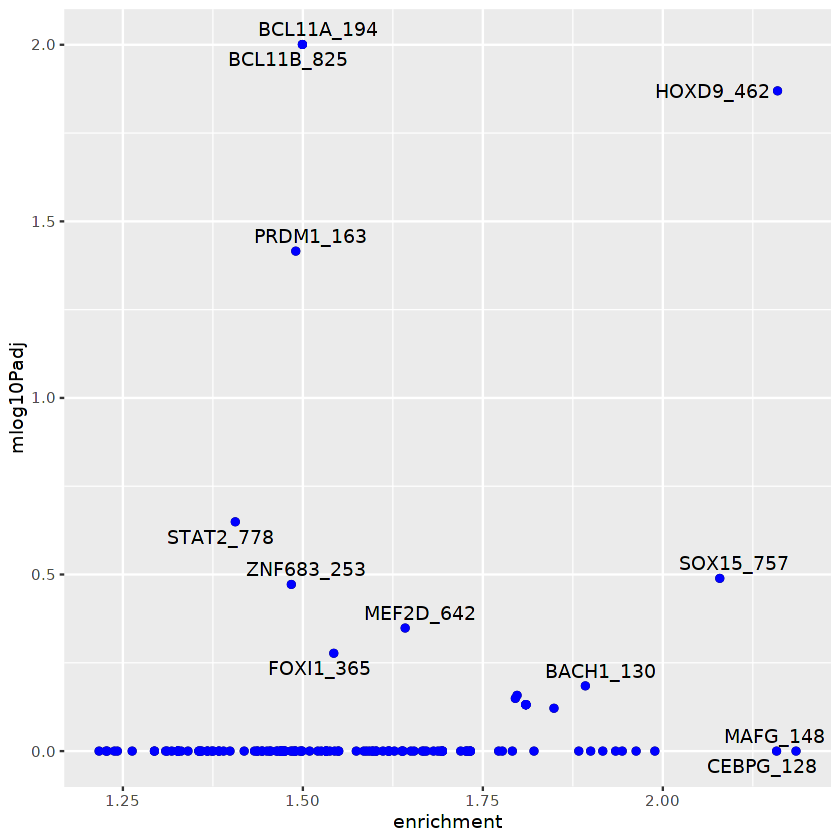

In [47]:
ggplot(data=sig_enrichment, aes(x=enrichment, y=mlog10Padj,label = rownames(sig_enrichment))) +
  geom_point()  + geom_text_repel() +
  geom_point(color = 'blue') 